## Read CSV file

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("../../data/malaysia_house_price_data_2025.csv")
df.head()

,Township,Area,State,Tenure,Type,Median_Price,Median_PSF,Transactions
0,SCIENTEX SUNGAI DUA,Tasek Gelugor,Penang,Freehold,Terrace House,331800,304,593
1,BANDAR PUTRA,Kulai,Johor,Freehold,"Cluster House, Terrace House",590900,322,519
2,TAMAN LAGENDA TROPIKA TAPAH,Chenderiang,Perak,Freehold,Terrace House,229954,130,414
3,SCIENTEX JASIN MUTIARA,Bemban,Melaka,Freehold,Terrace House,255600,218,391
4,TAMAN LAGENDA AMAN,Tapah,Perak,Leasehold,Terrace House,219300,168,363


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Township      2000 non-null   object
 1   Area          2000 non-null   object
 2   State         2000 non-null   object
 3   Tenure        2000 non-null   object
 4   Type          2000 non-null   object
 5   Median_Price  2000 non-null   int64 
 6   Median_PSF    2000 non-null   int64 
 7   Transactions  2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 125.1+ KB


## Preprocessing

In [4]:
df.isnull().sum().sum()


np.int64(0)

In [5]:
df.duplicated().sum()

df.drop_duplicates()

,Township,Area,State,Tenure,Type,Median_Price,Median_PSF,Transactions
0,SCIENTEX SUNGAI DUA,Tasek Gelugor,Penang,Freehold,Terrace House,331800,304,593
1,BANDAR PUTRA,Kulai,Johor,Freehold,"Cluster House, Terrace House",590900,322,519
2,TAMAN LAGENDA TROPIKA TAPAH,Chenderiang,Perak,Freehold,Terrace House,229954,130,414
3,SCIENTEX JASIN MUTIARA,Bemban,Melaka,Freehold,Terrace House,255600,218,391
4,TAMAN LAGENDA AMAN,Tapah,Perak,Leasehold,Terrace House,219300,168,363
...,...,...,...,...,...,...,...,...
1995,TAMAN ANDALAS JAYA,Klang,Selangor,Freehold,Terrace House,655000,410,10
1996,TAMAN ANJUNG BERCHAM MEGAH,Ipoh,Perak,Freehold,Terrace House,337500,224,10
1997,TAMAN PUNCAK JELAPANG MAJU,Ipoh,Perak,Leasehold,"Terrace House, Semi D",290000,195,10
1998,TAMAN TIONG UNG SIEW,Sibu,Sarawak,Leasehold,Terrace House,480000,272,10


## Feature Engineering

In [ ]:
# Average Regional Price (GroupBy Township or State)
# First calculate the average price for each township
township_avg = df.groupby("Township")["Median_Price"].mean().reset_index()
township_avg.rename(columns={"Median_Price": "Township_AvgPrice"}, inplace=True)

# merge with original table
df = df.merge(township_avg, on="Township", how="left")

# state 
state_avg = df.groupby("State")["Median_Price"].mean().reset_index()
state_avg.rename(columns={"Median_Price": "State_AvgPrice"}, inplace=True)
df = df.merge(state_avg, on="State", how="left")

# -------------------
# price per square foot
df["Price_per_Sqft"] = df["Median_Price"] / (df["Median_PSF"] + 1e-5)  # avoid devision by 0


## Split Dataset

In [ ]:
X = df.drop(columns=["Median_Price", "Median_PSF", "Transactions"], axis=1)
df["Median_Price"] = df["Median_Price"].clip(lower=1) # prevent negative and 0 price
y = np.log1p(df["Median_Price"]) # applies log transformation to reduce skewness in prices and make them more normal.

# one hot encoding
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalization
scaler = RobustScaler() # reducing the influence of outliers.
X_train = scaler.fit_transform(X=X_train)
X_test = scaler.transform(X=X_test)



**Correlationship** 

In [8]:
# Correlation analysis for regression features
correlation_matrix = X.corr()
print(correlation_matrix)

                                          Township_AvgPrice  State_AvgPrice  \
Township_AvgPrice                                  1.000000        0.330530   
State_AvgPrice                                     0.330530        1.000000   
Price_per_Sqft                                     0.483684       -0.104603   
Township_1 TANJUNG                                -0.009182       -0.023113   
Township_10 Mont Kiara @ MK10                      0.136882        0.051812   
...                                                     ...             ...   
Type_Town House, Bungalow, Terrace House           0.098584        0.014810   
Type_Town House, Semi D                            0.007627       -0.000814   
Type_Town House, Semi D, Terrace House             0.026297       -0.022973   
Type_Town House, Terrace House                     0.010991       -0.016312   
Type_Town House, Terrace House, Semi D             0.000441       -0.028512   

                                          Price_per

In [9]:
print("Min Median Price:", df["Median_Price"].min())
print("Max Median Price:", df["Median_Price"].max())

Min Median Price: 27049
Max Median Price: 11420500


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

randomForestModel = RandomForestRegressor(n_estimators=200, min_samples_split=2, random_state=42, max_depth=50, min_samples_leaf=1)
randomForestModel.fit(X_train, y_train)
y_pred_log = randomForestModel.predict(X_test)

y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_log)
scores_rf = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=42),
                            X, y, cv=5, scoring="r2")
print("Random Forest R² scores:", scores_rf)
print("Average Random Forest R²:", scores_rf.mean())
mse = mean_squared_error(y_true=y_test_original, y_pred=y_pred_original)
print(f"MAE:  {mean_absolute_error(y_true=y_test_original, y_pred=y_pred_original):.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"R2:   {r2_score(y_true=y_test_original, y_pred=y_pred_original):.4f}")


Random Forest R² scores: [0.9740208  0.9736211  0.97194286 0.97671872 0.98867281]
Average Random Forest R²: 0.9769952597244638
MAE:  8379.33
MSE:  927488909.39
RMSE: 30454.70
R2:   0.9947


### **Tuning**

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 30, 50, 70],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=2, scoring='r2', n_jobs=-1)
grid_search.fit(X=X_train, y=y_train)

print("Best Params: ", grid_search.best_params_)
print("Best R2: ", grid_search.best_score_)


Best Params:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
Best R2:  0.9823772157289079


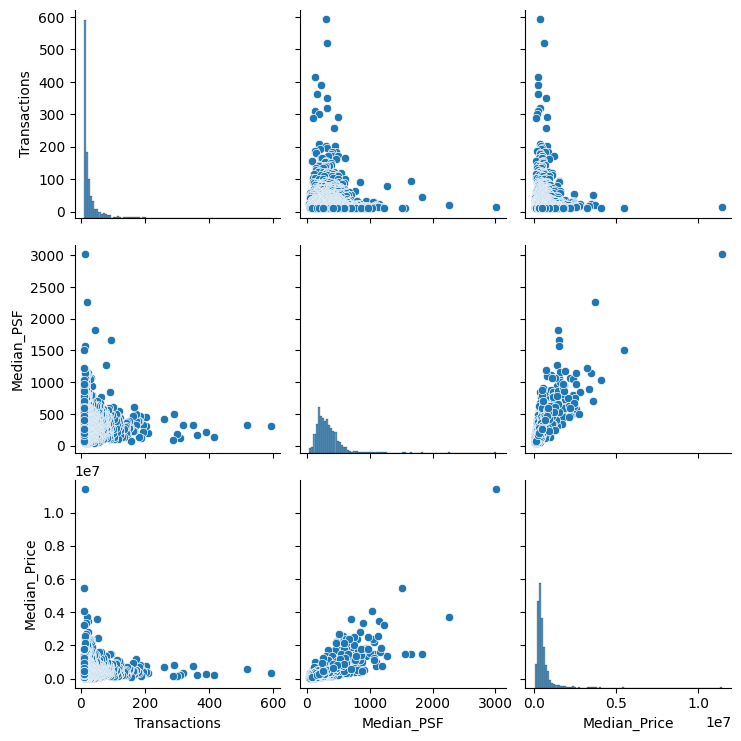

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot to visualize relationships
sns.pairplot(df[['Transactions', 'Median_PSF', 'Median_Price']])
plt.show()

# Heatmap for correlation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


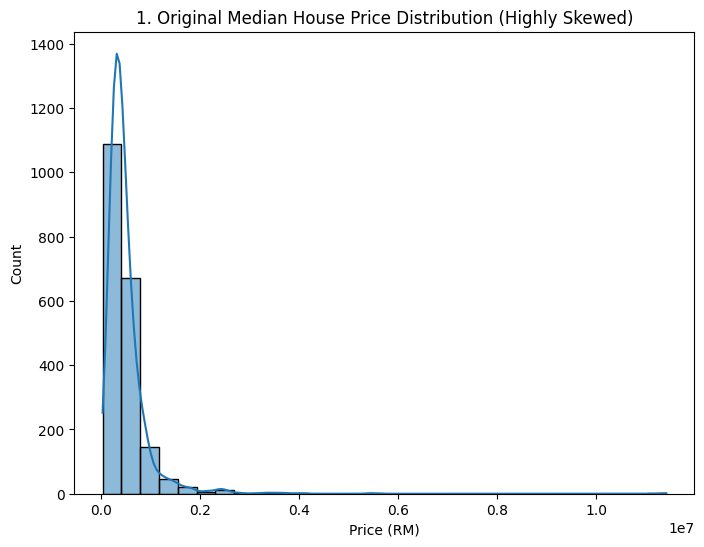

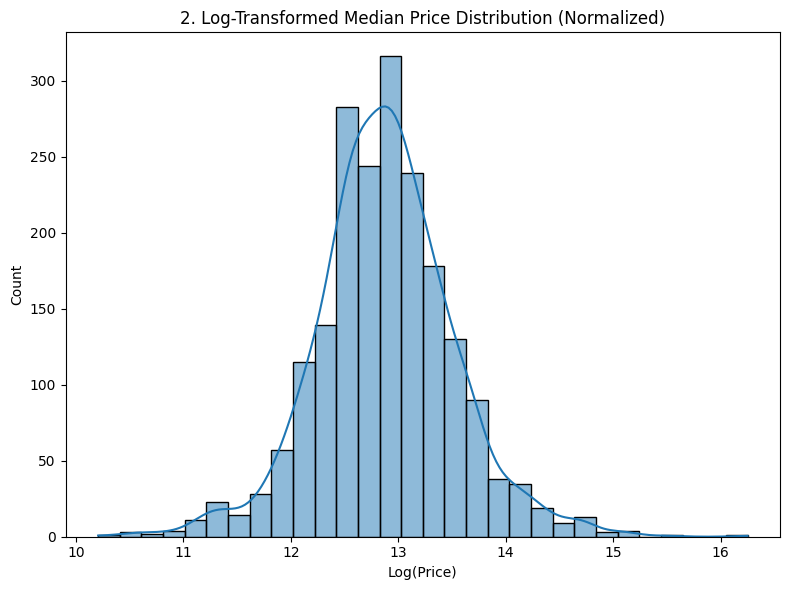

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.histplot(data=df["Median_Price"], kde=True, bins=30) #type: ignore
plt.title("1. Original Median House Price Distribution (Highly Skewed)")
plt.xlabel("Price (RM)")
plt.ylabel("Count")

plt.figure(figsize=(8,6))
sns.histplot(np.log(df["Median_Price"]), kde=True, bins=30)
plt.title("2. Log-Transformed Median Price Distribution (Normalized)")
plt.xlabel("Log(Price)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

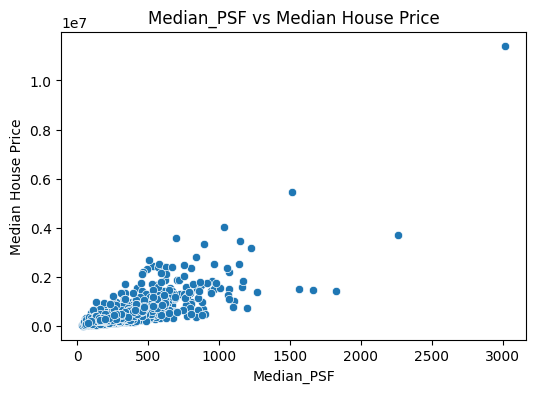

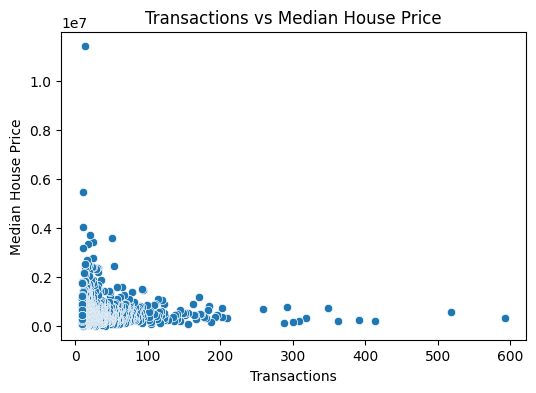

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_features = ["Median_PSF", "Transactions"]

for feature in num_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df["Median_Price"])
    plt.title(f"{feature} vs Median House Price")
    plt.xlabel(feature)
    plt.ylabel("Median House Price")
    plt.show()

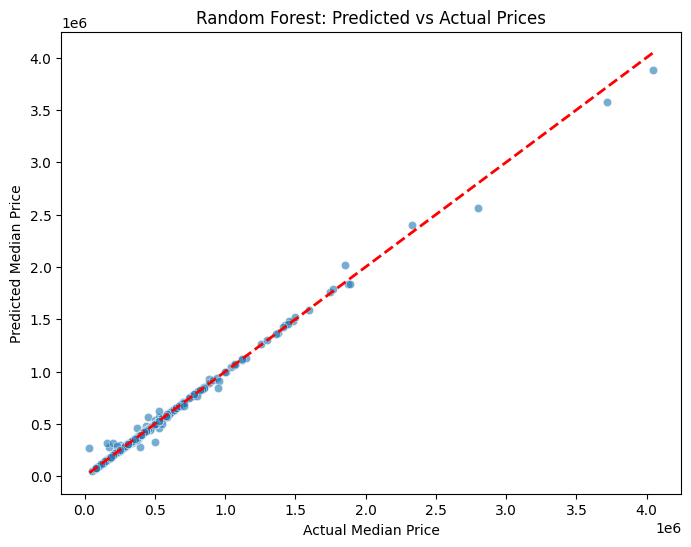

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', lw=2) 
plt.xlabel("Actual Median Price")
plt.ylabel("Predicted Median Price")
plt.title("Random Forest: Predicted vs Actual Prices")
plt.show()